In [ ]:
# Global variables for paths
DATA_PATH = "/work/nlp_final/data.csv"
BASE_DIR = "/work/nlp_final/training_sets"
SMOTE_DIR = f"{BASE_DIR}/smote"
ADASYN_DIR = f"{BASE_DIR}/adasyn"
MODEL_DIR = f"{BASE_DIR}/saved_models"
RESULTS_DIR = "/work/nlp_final/"

# File paths
BASELINE_RESULTS_FILE = f"{RESULTS_DIR}/model_results_baselines.csv"
ADVANCED_RESULTS_FILE = f"{RESULTS_DIR}/model_results_advanced_fusions.csv"

In [1]:
# NECESSARY INSTALL TO WORK IN DEEPNOTE
!pip install torch==2.1.2+cpu --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.9/184.9 MB 13.7 MB/s eta 0:00:00
  Obtaining dependency information for networkx from https://download.pytorch.org/whl/networkx-3.3-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 108.1 MB/s eta 0:00:00
Using cached https://download.pytorch.org/whl/networkx-3.3-py3-none-any.whl (1.7 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1
    Uninstalling torch-1.12.1:
      Successfully uninstalled torch-1.12.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1 requires torch==1.12.1, but you have torch 2.1.2+cpu which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
#load all of our necessary libraries
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import re
import gc
import math
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#date and time related
from datetime import datetime, timedelta
from time import time
from pathlib import Path

#NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from langdetect import detect, LangDetectException

#vectorizing and embedding
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sentence_transformers import SentenceTransformer

#preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    f1_score, fbeta_score, roc_auc_score, average_precision_score,
    accuracy_score, precision_score, recall_score, make_scorer
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE, ADASYN

#tensorflow - keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

#better machine performance
tf.config.threading.set_intra_op_parallelism_threads(16)
tf.config.threading.set_inter_op_parallelism_threads(4)

#visualizing
from pandas.plotting import scatter_matrix

#helper utilities
from collections import Counter
from tqdm.auto import tqdm
import joblib
from joblib import Parallel, delayed
import warnings

#torch
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

nltk.download('stopwords')
nltk.download('wordnet')

seed_value = 42

/root/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-28 14:15:06.479530: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-28 14:15:06.483602: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-28 14:15:06.515459: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-28 14:15:06.515574: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to regis

# Model training

A - Audio, L - Linguistic, T - Text (lyrics)

We will be training the following models with different feature sets, so we now need to split accordingly:

**Baselines (one modality each)**

| ID | Feature set                            | Models & notes                                             | Gotchas                                                    |
|----|----------------------------------------|------------------------------------------------------------|------------------------------------------------------------|
| 1  | Audio features only (≈13 Spotify floats) | LogReg · RF · MLP                                          | Nice reference for “music-only” signal.                   |
| 2  | Lyric metrics only (3–5 numeric)        | LogReg · RF · MLP                                          | Expect low recall but useful as structure-only yard-stick. |
| 3  | Lyrics → BoW / TF-IDF                   | NB                                        | Keep vocab to English subset; NB gives a classic text baseline. |
| 4  | Lyrics → Dense Embeddings (fastText avg or BERT-CLS) | LogReg · RF · MLP                                | Dense → MLP fits; also test LogisticR for linear separability. |

**Advanced Fusions**

| ID | Feature combo                                 | Models                 | Purpose                                                        |
|----|-----------------------------------------------|------------------------|----------------------------------------------------------------|
| 5  | Lyrics (embeddings) + Lyric metrics           | LogReg · RF · MLP      | Checks if handcrafted stats add marginal lift over embeddings. |
| 6  | Lyrics (embeddings) + Audio                   | LogReg · RF · MLP      | Content + sound interactions. Often the sweet spot.            |
| 7  | All three (Lyrics emb + Metrics + Audio)      | LogReg · RF · Hybrid-MLP | Full-information test; hybrid MLP with dual inputs recommended. |

# Splitting into sets

In [3]:
spotify_merged = pd.read_csv(DATA_PATH)
spotify_merged

,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,peak_rank,peak_normalized,hit,lyrics,ly_num_chars,ly_vocab_size,ly_ttr,ly_top5_ratio,ly_ngram_repetition,ly_rhyme_like_ratio
0,0VdcSHXCPRfQQZYQPXSlZ9,0.364,0.126,7,-18.071,1,0.0286,0.86200,0.000203,0.0969,...,0,0.000000,0,i found her diary underneath a tree and starte...,928.0,85.0,0.435897,0.215385,0.015625,0.000000
1,60NxxZzE3CFzuCgQmhqNi0,0.287,0.883,9,-6.383,1,0.0462,0.00116,0.000949,0.1550,...,0,0.000000,0,i get violent when i'm fucked up i get silent ...,619.0,76.0,0.550725,0.239130,0.007407,0.036496
2,0BSPhsCKfwENstErymcD80,0.624,0.803,9,-5.107,0,0.2180,0.04530,0.000000,0.3180,...,0,0.000000,0,"the ghetto othello, the moor oh my god, they s...",5921.0,291.0,0.250000,0.161512,0.010336,0.012038
3,5gGMmuBXnT9ywO8gklzWkc,0.639,0.711,0,-7.149,1,0.0273,0.10500,0.165000,0.2440,...,0,0.000000,0,i've got sunshine on a cloudy day. when it's c...,720.0,62.0,0.380368,0.355828,0.050000,0.037037
4,1Lsrh6dwQW98CbWfCbwf57,0.458,0.266,7,-12.223,0,0.0316,0.16100,0.000000,0.0997,...,0,0.000000,0,"she puts on her work clothes, fishnet panty ho...",1024.0,109.0,0.547739,0.231156,0.015306,0.005051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35676,1VbhR6D6zUoSTBzvnRonXO,0.678,0.491,5,-5.815,1,0.0358,0.56500,0.000028,0.0772,...,2,0.989899,1,"you and me, we made a vow for better or for wo...",1117.0,91.0,0.339552,0.369403,0.026415,0.007491
35677,0M98PvIvx7vZ8LDpzMw1hB,0.738,0.861,2,-4.141,1,0.2370,0.32000,0.001750,0.3250,...,22,0.787879,1,"yeah, yeah, yeah blackpink in your area yeah, ...",1410.0,163.0,0.501538,0.212308,0.015528,0.083333
35678,5ETe7SElBIgm2NAZY3SpX4,0.476,0.991,10,-3.458,1,0.0520,0.04460,0.005740,0.1280,...,49,0.515152,1,long truck bed hop in it ♪ fire engine red lik...,1501.0,121.0,0.384127,0.193651,0.016026,0.000000
35679,5NU40QTlXrDUJzDBdv79bg,0.677,0.633,7,-7.831,1,0.0771,0.03140,0.000000,0.1120,...,76,0.242424,1,when i'm in my thoughts sometimes it's hard to...,1893.0,111.0,0.246667,0.368889,0.026846,0.022272


In [4]:
#output folder definition
os.makedirs(BASE_DIR, exist_ok=True)

audio_features = [
    'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'
]
lyrical_features = [
    'ly_num_chars', 'ly_vocab_size', 'ly_ttr', 'ly_top5_ratio',
    'ly_ngram_repetition', 'ly_rhyme_like_ratio'
]
text_features = ['lyrics']

feature_sets = {
    "A": audio_features,
    "L": lyrical_features,
    "T": text_features,
    "L_T": lyrical_features + text_features,
    "L_A": lyrical_features + audio_features,
    "T_A": text_features + audio_features,
    "A_L_T": audio_features + lyrical_features + text_features
}

y = spotify_merged['hit']

#creating all of the splits
for name, features in feature_sets.items():
    X = spotify_merged[features]

    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=0.15, random_state=42, stratify=y
    )

    val_size = 0.15 / 0.85  # fraction of train_val that should go to val
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size, random_state=42, stratify=y_train_val
    )

    #exporting to csv
    X_train.to_csv(f"{BASE_DIR}/X_train_{name}.csv", index=False)
    X_val.to_csv(f"{BASE_DIR}/X_val_{name}.csv", index=False)
    X_test.to_csv(f"{BASE_DIR}/X_test_{name}.csv", index=False)
    y_train.to_csv(f"{BASE_DIR}/y_train_{name}.csv", index=False)
    y_val.to_csv(f"{BASE_DIR}/y_val_{name}.csv", index=False)
    y_test.to_csv(f"{BASE_DIR}/y_test_{name}.csv", index=False)

    print(f"Saved training/validation/test sets for feature group: {name}")

Saved training/validation/test sets for feature group: A
Saved training/validation/test sets for feature group: L
Saved training/validation/test sets for feature group: T
Saved training/validation/test sets for feature group: L_T
Saved training/validation/test sets for feature group: L_A
Saved training/validation/test sets for feature group: T_A
Saved training/validation/test sets for feature group: A_L_T


# Creating BoW, TF-IDF and embeddings

The code has been rewritten to include garbage collection and process datasets in chunks, to be able to fit into the memory. 

In [5]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return ' '.join(tokens)

def vectorize_text_single(train_texts, texts, method="tfidf", max_features=2000):
    if method == "tfidf":
        vectorizer = TfidfVectorizer(max_features=max_features)
    elif method == "bow":
        vectorizer = CountVectorizer(max_features=max_features)
    else:
        raise ValueError("Invalid method")
    vectorizer.fit(train_texts)
    return vectorizer.transform(texts).toarray()

def sbert_encode(texts):
    return sbert_model.encode(texts, batch_size=64, show_progress_bar=True)

def load_lyrics(split):
    df = pd.read_csv(base_dir / f"X_{split}_T.csv")
    return df[text_column].fillna("").tolist()

def get_embedding(method, split, lyrics):
    if method == "sbert":
        return sbert_encode(lyrics)
    if method not in vectorizer_cache:
        train_lyrics = lyrics_cache["train"]
        if method == "tfidf":
            vec = TfidfVectorizer(preprocessor=clean_text, max_features=50)
        else:
            vec = CountVectorizer(preprocessor=clean_text, max_features=50)
        vec.fit(train_lyrics)
        vectorizer_cache[method] = vec
    vec = vectorizer_cache[method]
    return vec.transform(lyrics).toarray()

In [6]:
#double-checking that lyrics are consistent across csv's, so we don't have to apply BERT individually to all of them
base_dir = Path(BASE_DIR)
text_column = "lyrics"

feature_sets_to_check = ["T", "L_T", "A_L_T"]
splits = ["train", "val", "test"]

for split in splits:
    print(f"\n Checking lyrics consistency for split: {split.upper()}")
    
    lyrics_columns = []

    for fs in feature_sets_to_check:
        file_path = base_dir / f"X_{split}_{fs}.csv"
        df = pd.read_csv(file_path)

        if text_column not in df.columns:
            print(f"'{text_column}' column not found in {file_path.name}")
            break

        lyrics_columns.append(df[text_column])

    base_lyrics = lyrics_columns[0]
    all_match = all(base_lyrics.equals(other) for other in lyrics_columns[1:])

    if all_match:
        print(f"All 'lyrics' columns match for {split.upper()}")
    else:
        print(f"Mismatch found in 'lyrics' columns for {split.upper()}")


 Checking lyrics consistency for split: TRAIN
All 'lyrics' columns match for TRAIN

 Checking lyrics consistency for split: VAL
All 'lyrics' columns match for VAL

 Checking lyrics consistency for split: TEST
All 'lyrics' columns match for TEST


In [61]:
base_dir = Path(BASE_DIR)
text_column = "lyrics"
sbert_model = SentenceTransformer("all-MiniLM-L6-v2", device=device)

vectorizer_cache = {}
embedding_cache = {"tfidf": {}, "bow": {}, "sbert": {}}
lyrics_cache = {}


embedding_sets = {
    "T": ["tfidf", "bow", "sbert"],
    "L_T": ["sbert"],
    "A_L_T": ["sbert"]
}


chunk_size = 500  # Reduce if needed

sbert_split_cache = {}


for name, methods in embedding_sets.items():
    print(f"\nProcessing feature set: {name}")
    for split in ["train", "val", "test"]:
        file_path = base_dir / f"X_{split}_{name}.csv"
        df = pd.read_csv(file_path)

        if split not in lyrics_cache:
            lyrics_cache[split] = load_lyrics(split)
        lyrics = lyrics_cache[split]

        non_lyrics_cols = [col for col in df.columns if col != text_column]
        df_nonlyrics = df[non_lyrics_cols]

        for method in methods:
            print(f"{split.upper()} - {method.upper()}")
            out_file = base_dir / f"X_{split}_{name}_{method}.csv"
            header_written = False
            start_time = time()

            if method == "sbert" and split not in sbert_split_cache:
                print(f"   Computing SBERT for {split.upper()} once...")
                sbert_split_cache[split] = get_embedding("sbert", split, lyrics)

            if out_file.exists():
                out_file.unlink()
        
            num_chunks = math.ceil(len(lyrics) / chunk_size)
            for start in tqdm(range(0, len(lyrics), chunk_size), desc=f"   {split.upper()} - {method.upper()}", leave=False, total=num_chunks):

                end = min(start + chunk_size, len(lyrics))
                batch_lyrics = lyrics[start:end]
                batch_df = df_nonlyrics.iloc[start:end]

                if method == "sbert":
                    emb = sbert_split_cache[split][start:end]
                else:
                    emb = get_embedding(method, split, batch_lyrics)

                emb_cols = [f"{method}_{i}" for i in range(emb.shape[1])]

                # Combine embeddings and original features
                combined_cols = batch_df.columns.tolist() + emb_cols
                batch_combined = pd.DataFrame(
                    np.hstack([batch_df.to_numpy(), emb]),
                    columns=combined_cols
                )

                batch_combined.to_csv(
                    out_file,
                    mode='a',
                    index=False,
                    header=not header_written
                )
                header_written = True
                del emb, batch_combined, batch_lyrics, batch_df
                gc.collect()

            elapsed = timedelta(seconds=round(time() - start_time))
            print(f"   {split.upper()} - {method.upper()} completed in {elapsed}")

print("\nDone embedding lyrics for all relevant feature sets.")

/root/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

Processing feature set: T_A
TRAIN - SBERT
   Computing SBERT for TRAIN once...
Batches: 100%|██████████| 391/391 [06:50<00:00,  1.05s/it]
   TRAIN - SBERT completed in 0:08:34
VAL - SBERT
   Computing SBERT for VAL once...
Batches: 100%|██████████| 84/84 [00:51<00:00,  1.62it/s]
   VAL - SBERT completed in 0:01:05
TEST - SBERT
   Computing SBERT for TEST once...
Batches: 100%|██████████| 84/84 [00:52<00:00,  1.62it/s]
                                                                   TEST - SBERT completed in 0:01:07

Done embedding lyrics for all relevant feature sets.


In [8]:
pd.read_csv(os.path.join(BASE_DIR, "X_train_A_L_T.csv"))

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,ly_num_chars,ly_vocab_size,ly_ttr,ly_top5_ratio,ly_ngram_repetition,ly_rhyme_like_ratio,lyrics
0,0.502,0.802,1,-5.534,1,0.0301,0.000296,0.000008,0.0873,0.528,164.025,1812.0,77.0,0.182033,0.371158,0.019048,0.037915,all these years i had to do it all but there's...
1,0.185,0.927,2,-6.341,1,0.1100,0.000083,0.004040,0.3670,0.475,160.053,963.0,95.0,0.487179,0.230769,0.020833,0.010309,twenty-twenty hindsight looking through the pa...
2,0.819,0.699,8,-7.291,0,0.0469,0.014400,0.000000,0.3750,0.478,96.049,1267.0,98.0,0.342657,0.262238,0.021201,0.000000,"she say i'm her favorite, it's probably 'cause..."
3,0.483,0.753,4,-7.709,0,0.0330,0.000371,0.030700,0.3960,0.375,139.091,1005.0,101.0,0.487923,0.270531,0.024510,0.038835,headstrong is willing to live like a rat in a ...
4,0.631,0.786,9,-5.267,1,0.0346,0.007440,0.000000,0.1210,0.770,102.038,1620.0,68.0,0.202381,0.217262,0.027027,0.032836,feel it i can feel it coming you're touching m...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24971,0.365,0.881,7,-11.154,1,0.1000,0.002340,0.030300,0.1410,0.699,187.208,903.0,86.0,0.443299,0.247423,0.031414,0.041451,get outta my way i'm gettin' tired of you ther...
24972,0.391,0.933,5,-4.282,1,0.0384,0.000026,0.102000,0.3050,0.508,173.790,697.0,73.0,0.561538,0.200000,0.023622,0.000000,ideals of beauty set to color in savvy death c...
24973,0.318,0.401,5,-7.457,1,0.0288,0.245000,0.000002,0.0854,0.390,82.228,1010.0,58.0,0.244726,0.379747,0.047009,0.000000,i see you all alone don't live this on your ow...
24974,0.652,0.183,7,-12.277,0,0.0308,0.899000,0.000004,0.0995,0.205,108.453,945.0,91.0,0.443902,0.239024,0.034653,0.044118,oh let us rise above the bones let us remember...


In [9]:
pd.read_csv(os.path.join(BASE_DIR, "X_train_A_L_T_sbert.csv"))

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,sbert_374,sbert_375,sbert_376,sbert_377,sbert_378,sbert_379,sbert_380,sbert_381,sbert_382,sbert_383
0,0.502,0.802,1.0,-5.534,1.0,0.0301,0.000296,0.000008,0.0873,0.528,...,0.034647,0.054630,-0.028913,0.021920,-0.050752,0.014212,0.012591,-0.038841,-0.045183,-0.061978
1,0.185,0.927,2.0,-6.341,1.0,0.1100,0.000083,0.004040,0.3670,0.475,...,-0.012657,0.013778,0.000147,0.026187,-0.076674,0.040308,0.051180,-0.049584,-0.112146,-0.056666
2,0.819,0.699,8.0,-7.291,0.0,0.0469,0.014400,0.000000,0.3750,0.478,...,-0.011199,-0.047934,0.005279,0.068954,0.002925,0.002272,0.022385,0.049790,-0.034069,-0.037149
3,0.483,0.753,4.0,-7.709,0.0,0.0330,0.000371,0.030700,0.3960,0.375,...,0.061764,0.045412,0.030553,0.047732,-0.100359,0.020843,-0.031736,-0.016674,0.048742,-0.055884
4,0.631,0.786,9.0,-5.267,1.0,0.0346,0.007440,0.000000,0.1210,0.770,...,-0.051279,0.016698,-0.082679,0.065463,0.026813,-0.003655,0.057492,0.020748,-0.080340,0.011583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24971,0.365,0.881,7.0,-11.154,1.0,0.1000,0.002340,0.030300,0.1410,0.699,...,-0.017891,0.007692,-0.042174,0.013537,-0.090727,0.054558,-0.140509,0.020666,0.040728,-0.088569
24972,0.391,0.933,5.0,-4.282,1.0,0.0384,0.000026,0.102000,0.3050,0.508,...,0.001814,-0.036326,0.038793,0.118117,-0.027804,0.032837,0.060257,-0.022133,-0.006226,-0.063061
24973,0.318,0.401,5.0,-7.457,1.0,0.0288,0.245000,0.000002,0.0854,0.390,...,0.005735,0.059878,-0.001842,0.065405,0.044191,0.006666,0.072328,0.062570,-0.000790,-0.073453
24974,0.652,0.183,7.0,-12.277,0.0,0.0308,0.899000,0.000004,0.0995,0.205,...,0.007335,0.083646,-0.013032,0.057772,0.019942,0.039902,0.018212,0.012766,0.005391,-0.101596


In [10]:
pd.read_csv(os.path.join(BASE_DIR, "X_val_T_bow.csv"))

,bow_0,bow_1,bow_2,bow_3,bow_4,bow_5,bow_6,bow_7,bow_8,bow_9,...,bow_40,bow_41,bow_42,bow_43,bow_44,bow_45,bow_46,bow_47,bow_48,bow_49
0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,2.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,8.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
5348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0
5349,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
5350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
pd.read_csv(os.path.join(BASE_DIR, "X_val_T_tfidf.csv"))

,tfidf_0,tfidf_1,tfidf_2,tfidf_3,tfidf_4,tfidf_5,tfidf_6,tfidf_7,tfidf_8,tfidf_9,...,tfidf_40,tfidf_41,tfidf_42,tfidf_43,tfidf_44,tfidf_45,tfidf_46,tfidf_47,tfidf_48,tfidf_49
0,0.0,0.0,0.693193,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.454956,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.281292
1,0.0,0.0,0.061868,0.000000,0.000000,0.000000,0.049992,0.000000,0.0,0.000000,...,0.000000,0.000000,0.157641,0.0,0.000000,0.000000,0.0,0.00000,0.027560,0.000000
2,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.204876,...,0.000000,0.000000,0.000000,0.0,0.489543,0.000000,0.0,0.00000,0.000000,0.063336
3,0.0,0.0,0.000000,0.095594,0.000000,0.000000,0.089361,0.106389,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.635256,0.0,0.00000,0.000000,0.718017
4,0.0,0.0,0.000000,0.055654,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.052834,0.0,0.00000,0.000000,0.992796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5347,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.174868,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.389891
5348,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.385660,0.000000,0.0,0.000000,0.000000,0.0,0.39598,0.000000,0.316385
5349,0.0,0.0,0.000000,0.000000,0.140397,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.669418,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.549173
5350,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.000000


# Oversampling

Only applied to sBERT - not BoW or TF-IDF, since these are sparse high-dimensional vectors. SMOTE and ADASYN assume Euclidean space and continuous features. 

In [62]:
base_dir = Path(BASE_DIR)
output_smote = base_dir / "smote"
output_adasyn = base_dir / "adasyn"
output_smote.mkdir(exist_ok=True)
output_adasyn.mkdir(exist_ok=True)


eligible_files = [
    ("A", None),
    ("L", None),
    ("T", "sbert"),
    ("L_A", None),
    ("L_T", "sbert"),
    ("T_A", "sbert"),
    ("A_L_T", "sbert"),
]


for feature_set, embedding in eligible_files:
    suffix = f"_{embedding}" if embedding else ""
    X_file = base_dir / f"X_train_{feature_set}{suffix}.csv"
    y_file = base_dir / f"y_train_{feature_set}.csv"

    if not X_file.exists() or not y_file.exists():
        print(f"Missing {X_file.name} or {y_file.name} — skipping.")
        continue

    print(f"\nProcessing: {X_file.name}")
    
    try:
        X = pd.read_csv(X_file)
        y = pd.read_csv(y_file).squeeze()
        X_numeric = X.select_dtypes(include=[np.number])

        if X_numeric.empty:
            print("No numeric features — skipped.")
            continue

        print("Applying SMOTE...")
        smote = SMOTE(random_state=42)
        X_sm, y_sm = smote.fit_resample(X_numeric, y)
        X_sm.to_csv(output_smote / f"X_train_{feature_set}{suffix}_SMOTE.csv", index=False)
        y_sm.to_csv(output_smote / f"y_train_{feature_set}{suffix}_SMOTE.csv", index=False)

        print("Applying ADASYN...")
        adasyn = ADASYN(random_state=42)
        X_ad, y_ad = adasyn.fit_resample(X_numeric, y)
        X_ad.to_csv(output_adasyn / f"X_train_{feature_set}{suffix}_ADASYN.csv", index=False)
        y_ad.to_csv(output_adasyn / f"y_train_{feature_set}{suffix}_ADASYN.csv", index=False)

        print(f"Done: {feature_set}{suffix}")

    except Exception as e:
        print(f"Error while processing {feature_set}{suffix}: {e}")
    finally:
        del X, y, X_numeric
        gc.collect()

print("\nOversampling complete.")


Processing: X_train_T_A_sbert.csv
Applying SMOTE...
Applying ADASYN...
Done: T_A_sbert

Oversampling complete.


<hr>

# Model training

## Baselines (one modality each)

| ID | Feature set                            | Models & notes                                             | Gotchas                                                    |
|----|----------------------------------------|------------------------------------------------------------|------------------------------------------------------------|
| 1  | Audio features only (≈13 Spotify floats) | LogReg · RF · MLP                                          | Nice reference for “music-only” signal.                   |
| 2  | Lyric metrics only (3–5 numeric)        | LogReg · RF · MLP                                          | Expect low recall but useful as structure-only yard-stick. |
| 3  | Lyrics → BoW / TF-IDF                   | NB                                         | Keep vocab to English subset; NB gives a classic text baseline. |
| 4  | Lyrics → Dense Embeddings (fastText avg or BERT-CLS) | LogReg · RF · MLP                                | Dense → MLP fits; also test LogisticR for linear separability. |

### Metrics

In [13]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, fbeta_score
)

def get_metrics(y_true, y_pred, y_proba=None):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "f2": fbeta_score(y_true, y_pred, beta=2, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_proba) if y_proba is not None else np.nan,
        "pr_auc": average_precision_score(y_true, y_proba) if y_proba is not None else np.nan
    }

### Naive Bayes

In [14]:
def run_naive_bayes(feature_sets, resample_types, base_dir, results):

    param_dist = {"alpha": [0.1, 0.5, 1.0, 2.0]}
    embeddings = ["tfidf", "bow"]
    f2_scorer = make_scorer(fbeta_score, beta=2, zero_division=0)

    for feature_set in tqdm(feature_sets, desc="Naive Bayes - Feature Sets"):
        for embedding in embeddings:
            for resample, dir_path in resample_types.items():
                suffix = f"_{embedding}"
                resample_suffix = "" if resample == "original" else f"_{resample}"
                X_train_path = dir_path / f"X_train_{feature_set}{suffix}{resample_suffix}.csv"
                if resample == "original":
                    y_train_path = dir_path / f"y_train_{feature_set}.csv"
                else:
                    y_train_path = dir_path / f"y_train_{feature_set}_{embedding}_{resample}.csv"
                X_val_path = base_dir / f"X_val_{feature_set}{suffix}.csv"
                y_val_path = base_dir / f"y_val_{feature_set}.csv"
                X_test_path = base_dir / f"X_test_{feature_set}{suffix}.csv"
                y_test_path = base_dir / f"y_test_{feature_set}.csv"
                if not (X_train_path.exists() and y_train_path.exists() and X_val_path.exists() and y_val_path.exists()):
                    continue


                X_train = pd.read_csv(X_train_path).astype(float)
                y_train = pd.read_csv(y_train_path).squeeze().astype(float)
                X_val = pd.read_csv(X_val_path).astype(float)
                y_val = pd.read_csv(y_val_path).squeeze().astype(float)
                X_test = pd.read_csv(X_test_path).astype(float)
                y_test = pd.read_csv(y_test_path).squeeze().astype(float)

                rs = GridSearchCV(
                    MultinomialNB(),
                    param_grid=param_dist,
                    scoring=f2_scorer, cv=3, n_jobs=-1
                )
                rs.fit(X_train, y_train)
                clf = rs.best_estimator_
                best_params = rs.best_params_

                val_pred = clf.predict(X_val)
                val_proba = clf.predict_proba(X_val)[:,1] if hasattr(clf, "predict_proba") else None
                test_pred = clf.predict(X_test) if X_test is not None else None
                test_proba = clf.predict_proba(X_test)[:,1] if (X_test is not None and hasattr(clf, "predict_proba")) else None

                val_metrics = get_metrics(y_val, val_pred, val_proba)
                test_metrics = get_metrics(y_test, test_pred, test_proba) if test_pred is not None else {}

                row = {
                    "feature_set": feature_set,
                    "embedding": embedding,
                    "resample": resample,
                    "model": "NaiveBayes",
                    **{f"val_{k}": v for k, v in val_metrics.items()},
                    **{f"test_{k}": v for k, v in test_metrics.items()},
                    "best_params": best_params
                }
                results.append(row)

### Logistic Regression

In [15]:
def run_logistic_regression(eligible_files, resample_types, base_dir, results):
    param_dist = {
        "C": [0.01, 0.1, 1, 10, 100],
        "penalty": ["l2"],
        "solver": ["lbfgs", "liblinear"]
    }

    f2_scorer = make_scorer(fbeta_score, beta=2, zero_division=0)

    for feature_set, embedding in tqdm(eligible_files, desc="Logistic Regression - Feature Sets"):
        suffix = f"_{embedding}" if embedding else ""

        for resample, dir_path in resample_types.items():
            resample_suffix = "" if resample == "original" else f"_{resample}"
            X_train_path = dir_path / f"X_train_{feature_set}{suffix}{resample_suffix}.csv"
            if resample == "original":
                y_train_path = dir_path / f"y_train_{feature_set}.csv"
            else:
                y_train_path = dir_path / f"y_train_{feature_set}{suffix}_{resample}.csv"

            X_val_path = base_dir / f"X_val_{feature_set}{suffix}.csv"
            y_val_path = base_dir / f"y_val_{feature_set}.csv"
            X_test_path = base_dir / f"X_test_{feature_set}{suffix}.csv"
            y_test_path = base_dir / f"y_test_{feature_set}.csv"

            if not (X_train_path.exists() and y_train_path.exists() and X_val_path.exists() and y_val_path.exists()):
                continue

            X_train = pd.read_csv(X_train_path).astype(float)
            y_train = pd.read_csv(y_train_path).squeeze().astype(float)
            X_val = pd.read_csv(X_val_path).astype(float)
            y_val = pd.read_csv(y_val_path).squeeze().astype(float)
            X_test = pd.read_csv(X_test_path).astype(float)
            y_test = pd.read_csv(y_test_path).squeeze().astype(float)

            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)
            X_test = scaler.transform(X_test) if X_test is not None else None

            rs = GridSearchCV(
                LogisticRegression(max_iter=200, random_state=42),
                param_grid=param_dist,
                scoring=f2_scorer,
                cv=3,
                n_jobs=-1
            )
            rs.fit(X_train, y_train)
            clf = rs.best_estimator_
            best_params = rs.best_params_

            val_pred = clf.predict(X_val)
            val_proba = clf.predict_proba(X_val)[:, 1] if hasattr(clf, "predict_proba") else None
            test_pred = clf.predict(X_test) if X_test is not None else None
            test_proba = clf.predict_proba(X_test)[:, 1] if (X_test is not None and hasattr(clf, "predict_proba")) else None

            val_metrics = get_metrics(y_val, val_pred, val_proba)
            test_metrics = get_metrics(y_test, test_pred, test_proba) if test_pred is not None else {}

            row = {
                "feature_set": feature_set,
                "embedding": embedding if embedding else "none",
                "resample": resample,
                "model": "LogisticRegression",
                **{f"val_{k}": v for k, v in val_metrics.items()},
                **{f"test_{k}": v for k, v in test_metrics.items()},
                "best_params": best_params
            }
            results.append(row)

# Random Forest

In [16]:
def run_random_forest(eligible_files, resample_types, base_dir, results):
    param_dist = {
        "n_estimators": [50, 100, 200],
        "max_depth": [5, 10, 20, None],
        "min_samples_split": [2, 5, 10],
        "class_weight": ["balanced", None]
    }

    f2_scorer = make_scorer(fbeta_score, beta=2, zero_division=0)

    model_output_dir = base_dir / "saved_models"
    model_output_dir.mkdir(parents=True, exist_ok=True)

    for feature_set, embedding in tqdm(eligible_files, desc="Random Forest - Feature Sets"):
        suffix = f"_{embedding}" if embedding else ""

        for resample, dir_path in resample_types.items():
            resample_suffix = "" if resample == "original" else f"_{resample}"
            print(f"\n--- Processing: Feature Set={feature_set}, Embedding={embedding or 'none'}, Resample={resample} ---")

            X_train_path = dir_path / f"X_train_{feature_set}{suffix}{resample_suffix}.csv"
            if resample == "original":
                y_train_path = dir_path / f"y_train_{feature_set}.csv"
            else:
                y_train_path = dir_path / f"y_train_{feature_set}{suffix}_{resample}.csv"

            X_val_path = base_dir / f"X_val_{feature_set}{suffix}.csv"
            y_val_path = base_dir / f"y_val_{feature_set}.csv"
            X_test_path = base_dir / f"X_test_{feature_set}{suffix}.csv"
            y_test_path = base_dir / f"y_test_{feature_set}.csv"

            if not (X_train_path.exists() and y_train_path.exists() and X_val_path.exists() and y_val_path.exists()):
                print("Skipping due to missing files.")
                continue

            print("Loading data...")
            X_train = pd.read_csv(X_train_path).astype(float)
            y_train = pd.read_csv(y_train_path).squeeze().astype(float)
            X_val = pd.read_csv(X_val_path).astype(float)
            y_val = pd.read_csv(y_val_path).squeeze().astype(float)
            X_test = pd.read_csv(X_test_path).astype(float)
            y_test = pd.read_csv(y_test_path).squeeze().astype(float)

            print("Starting hyperparameter tuning...")
            rs = GridSearchCV(
                RandomForestClassifier(random_state=42, n_jobs=-1),
                param_grid=param_dist,
                scoring=f2_scorer,
                cv=3,
                n_jobs=-1
            )
            rs.fit(X_train, y_train)
            clf = rs.best_estimator_
            best_params = rs.best_params_
            print(f"Best parameters: {best_params}")

            model_filename = f"rf_{feature_set}_{embedding or 'none'}_{resample}.joblib"
            joblib.dump(clf, model_output_dir / model_filename)
            print(f"Saved model to {model_output_dir / model_filename}")

            print("Evaluating on validation and test sets...")
            val_pred = clf.predict(X_val)
            val_proba = clf.predict_proba(X_val)[:, 1] if hasattr(clf, "predict_proba") else None
            test_pred = clf.predict(X_test) if X_test is not None else None
            test_proba = clf.predict_proba(X_test)[:, 1] if (X_test is not None and hasattr(clf, "predict_proba")) else None

            val_metrics = get_metrics(y_val, val_pred, val_proba)
            test_metrics = get_metrics(y_test, test_pred, test_proba) if test_pred is not None else {}

            print("Validation metrics:", val_metrics)
            print("Test metrics:", test_metrics)

            row = {
                "feature_set": feature_set,
                "embedding": embedding if embedding else "none",
                "resample": resample,
                "model": "RandomForest",
                **{f"val_{k}": v for k, v in val_metrics.items()},
                **{f"test_{k}": v for k, v in test_metrics.items()},
                "best_params": best_params
            }
            results.append(row)
            print("Results recorded.\n")

# MLP

In [17]:
def run_mlp(eligible_files, resample_types, base_dir, results):
    param_dist = {
        "hidden_layer_sizes": [
            (128, 64),
            (256, 128, 64),
            (384, 128, 32)
        ],
        "activation": ["relu", "tanh"],
        "alpha": [0.0001, 0.001, 0.01, 0.1],
        "learning_rate_init": [0.001, 0.01]
    }

    f2_scorer = make_scorer(fbeta_score, beta=2, zero_division=0)

    model_output_dir = base_dir / "saved_models"
    model_output_dir.mkdir(parents=True, exist_ok=True)

    for feature_set, embedding in tqdm(eligible_files, desc="MLP - Feature Sets"):
        suffix = f"_{embedding}" if embedding else ""

        for resample, dir_path in resample_types.items():
            resample_suffix = "" if resample == "original" else f"_{resample}"
            X_train_path = dir_path / f"X_train_{feature_set}{suffix}{resample_suffix}.csv"
            
            if resample == "original":
                y_train_path = dir_path / f"y_train_{feature_set}.csv"
            else:
                y_train_path = dir_path / f"y_train_{feature_set}{suffix}_{resample}.csv"

            X_val_path = base_dir / f"X_val_{feature_set}{suffix}.csv"
            y_val_path = base_dir / f"y_val_{feature_set}.csv"
            X_test_path = base_dir / f"X_test_{feature_set}{suffix}.csv"
            y_test_path = base_dir / f"y_test_{feature_set}.csv"

            if not (X_train_path.exists() and y_train_path.exists() and X_val_path.exists() and y_val_path.exists()):
                continue

            X_train = pd.read_csv(X_train_path).astype(float)
            y_train = pd.read_csv(y_train_path).squeeze().astype(float)
            X_val = pd.read_csv(X_val_path).astype(float)
            y_val = pd.read_csv(y_val_path).squeeze().astype(float)
            X_test = pd.read_csv(X_test_path).astype(float)
            y_test = pd.read_csv(y_test_path).squeeze().astype(float)

            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)
            X_test = scaler.transform(X_test) if X_test is not None else None

            mlp = GridSearchCV(
                MLPClassifier(max_iter=500, random_state=42, early_stopping=True, validation_fraction=0.1),
                param_grid=param_dist,
                scoring=f2_scorer,
                cv=3,
                n_jobs=-1
            )
            mlp.fit(X_train, y_train)
            clf = mlp.best_estimator_
            best_params = mlp.best_params_

            model_filename = f"mlp_{feature_set}_{embedding or 'none'}_{resample}.joblib"
            joblib.dump(clf, model_output_dir / model_filename)

            val_pred = clf.predict(X_val)
            val_proba = clf.predict_proba(X_val)[:, 1] if hasattr(clf, "predict_proba") else None
            test_pred = clf.predict(X_test) if X_test is not None else None
            test_proba = clf.predict_proba(X_test)[:, 1] if (X_test is not None and hasattr(clf, "predict_proba")) else None

            val_metrics = get_metrics(y_val, val_pred, val_proba)
            test_metrics = get_metrics(y_test, test_pred, test_proba) if test_pred is not None else {}

            row = {
                "feature_set": feature_set,
                "embedding": embedding if embedding else "none",
                "resample": resample,
                "model": "MLP",
                **{f"val_{k}": v for k, v in val_metrics.items()},
                **{f"test_{k}": v for k, v in test_metrics.items()},
                "best_params": best_params
            }
            results.append(row)

# Baseline models - results

| ID | Feature set                            | Models & notes                                             | Gotchas                                                    |
|----|----------------------------------------|------------------------------------------------------------|------------------------------------------------------------|
| 1  | Audio features only (≈13 Spotify floats) | LogReg · RF · MLP                                          | Nice reference for “music-only” signal.                   |
| 2  | Lyric metrics only (3–5 numeric)        | LogReg · RF · MLP                                          | Expect low recall but useful as structure-only yard-stick. |
| 3  | Lyrics → BoW / TF-IDF                   | NB                                        | Keep vocab to English subset; NB gives a classic text baseline. |
| 4  | Lyrics → Dense Embeddings (fastText avg or BERT-CLS) | LogReg · RF · MLP                                | Dense → MLP fits; also test LogisticR for linear separability. |

In [18]:
resample_types = {
    "original": base_dir,
    "SMOTE": base_dir / "smote",
    "ADASYN": base_dir / "adasyn"
}

eligible_files = [
    ("A", None),
    ("L", None),
    ("T", "sbert"),
]

results = []
run_naive_bayes(['T'], resample_types, base_dir, results) # will run on both TF-IDF and BoW automatically
run_logistic_regression(eligible_files, resample_types, base_dir, results)
run_random_forest(eligible_files, resample_types, base_dir, results)
run_mlp(eligible_files, resample_types, base_dir, results)

metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "F2 Score", "ROC AUC", "PR AUC"]

# Save all results to CSV
df_results = pd.DataFrame(results)
df_results.to_csv(BASELINE_RESULTS_FILE, index=False)
print("All model training complete. Results saved to model_results_baselines.csv")
df_results

Random Forest - Feature Sets:   0%|          | 0/3 [00:00<?, ?it/s]
--- Processing: Feature Set=A, Embedding=none, Resample=original ---
Loading data...
Starting hyperparameter tuning...
Best parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}
Saved model to training_sets/saved_models/rf_A_none_original.joblib
Evaluating on validation and test sets...
Validation metrics: {'accuracy': 0.9116218236173393, 'precision': 0.06540084388185655, 'recall': 0.5081967213114754, 'f1': 0.11588785046728972, 'f2': 0.21587743732590528, 'roc_auc': 0.8358641801264751, 'pr_auc': 0.08041010903857412}
Test metrics: {'accuracy': 0.8993087988044087, 'precision': 0.03861003861003861, 'recall': 0.32786885245901637, 'f1': 0.0690846286701209, 'f2': 0.13123359580052493, 'roc_auc': 0.7770637398857541, 'pr_auc': 0.0332708976620847}
Results recorded.


--- Processing: Feature Set=A, Embedding=none, Resample=SMOTE ---
Loading data...
Starting hyperparameter tuning...


,feature_set,embedding,resample,model,val_accuracy,val_precision,val_recall,val_f1,val_f2,val_roc_auc,val_pr_auc,test_accuracy,test_precision,test_recall,test_f1,test_f2,test_roc_auc,test_pr_auc,best_params
0,T,tfidf,original,NaiveBayes,0.988602,0.000000,0.000000,0.000000,0.000000,0.728382,0.038428,0.988605,0.000000,0.000000,0.000000,0.000000,0.679919,0.021364,{'alpha': 0.1}
1,T,bow,original,NaiveBayes,0.918909,0.044010,0.295082,0.076596,0.137825,0.657649,0.037294,0.916869,0.031707,0.213115,0.055202,0.099388,0.568873,0.019229,{'alpha': 1.0}
2,A,none,original,LogisticRegression,0.988602,0.000000,0.000000,0.000000,0.000000,0.776224,0.038303,0.988605,0.000000,0.000000,0.000000,0.000000,0.721488,0.029196,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}"
3,A,none,SMOTE,LogisticRegression,0.661435,0.023926,0.721311,0.046316,0.105617,0.770997,0.042924,0.657388,0.018991,0.573770,0.036765,0.083852,0.683751,0.029893,"{'C': 0.01, 'penalty': 'l2', 'solver': 'liblin..."
4,A,none,ADASYN,LogisticRegression,0.662930,0.024031,0.721311,0.046512,0.106024,0.771239,0.043015,0.658136,0.019032,0.573770,0.036842,0.084013,0.684835,0.030130,"{'C': 0.01, 'penalty': 'l2', 'solver': 'liblin..."
5,L,none,original,LogisticRegression,0.988602,0.000000,0.000000,0.000000,0.000000,0.806712,0.070774,0.988605,0.000000,0.000000,0.000000,0.000000,0.750034,0.026980,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}"
6,L,none,SMOTE,LogisticRegression,0.695254,0.029376,0.803279,0.056680,0.128138,0.800152,0.043800,0.671773,0.023060,0.672131,0.044589,0.101385,0.738712,0.030546,"{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}"
7,L,none,ADASYN,LogisticRegression,0.696375,0.029483,0.803279,0.056878,0.128541,0.801286,0.045176,0.674388,0.023243,0.672131,0.044932,0.102092,0.739251,0.030417,"{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}"
8,T,sbert,original,LogisticRegression,0.988229,0.250000,0.016393,0.030769,0.020161,0.790851,0.070980,0.988231,0.250000,0.016393,0.030769,0.020161,0.762636,0.065762,"{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}"
9,T,sbert,SMOTE,LogisticRegression,0.863976,0.043776,0.524590,0.080808,0.164103,0.776884,0.051962,0.855408,0.035202,0.442623,0.065217,0.133531,0.772583,0.056239,"{'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}"


# Advanced Fusions

| ID | Feature combo                                 | Models                 | Purpose                                                        |
|----|-----------------------------------------------|------------------------|----------------------------------------------------------------|
| 5  | Lyrics (embeddings) + Lyric metrics           | LogReg · RF · MLP      | Checks if handcrafted stats add marginal lift over embeddings. |
| 6  | Lyrics (embeddings) + Audio                   | LogReg · RF · MLP      | Content + sound interactions. Often the sweet spot.            |
| 7  | All three (Lyrics emb + Metrics + Audio)      | LogReg · RF · Hybrid-MLP | Full-information test; hybrid MLP with dual inputs recommended. |

<hr>

### Hybrid MLP Model

In [26]:
def run_hybrid_mlp(resample_types, base_dir, results, sbert_dim=384):
    """
    Train Hybrid-MLP on just the A_L_T set for each resample type (original, SMOTE, ADASYN).
    """
    feature_set = "A_L_T"
    suffix = "_sbert"
    model_output_dir = base_dir / "saved_models"
    model_output_dir.mkdir(parents=True, exist_ok=True)

    for resample, dir_path in resample_types.items():
        resample_suffix = "" if resample == "original" else f"_{resample}"
        X_train_path = dir_path / f"X_train_{feature_set}{suffix}{resample_suffix}.csv"
        y_train_path = dir_path / f"y_train_{feature_set}{suffix}{resample_suffix}.csv" if resample != "original" else dir_path / f"y_train_{feature_set}.csv"
        X_val_path = base_dir / f"X_val_{feature_set}{suffix}.csv"
        y_val_path = base_dir / f"y_val_{feature_set}.csv"
        X_test_path = base_dir / f"X_test_{feature_set}{suffix}.csv"
        y_test_path = base_dir / f"y_test_{feature_set}.csv"

        if not (X_train_path.exists() and y_train_path.exists() and X_val_path.exists() and y_val_path.exists()):
            print(f"Missing data for resample={resample}. Skipping.")
            continue

        X_train = pd.read_csv(X_train_path).to_numpy()
        y_train = pd.read_csv(y_train_path).values.ravel()
        X_val = pd.read_csv(X_val_path).to_numpy()
        y_val = pd.read_csv(y_val_path).values.ravel()
        X_test = pd.read_csv(X_test_path).to_numpy() if X_test_path.exists() else None
        y_test = pd.read_csv(y_test_path).values.ravel() if X_test_path.exists() else None

        sbert_dim = min(sbert_dim, X_train.shape[1])  # safety
        X_train_sbert, X_train_num = X_train[:, :sbert_dim], X_train[:, sbert_dim:]
        X_val_sbert, X_val_num = X_val[:, :sbert_dim], X_val[:, sbert_dim:]
        X_test_sbert, X_test_num = (X_test[:, :sbert_dim], X_test[:, sbert_dim:]) if X_test is not None else (None, None)

        input_sbert = Input(shape=(X_train_sbert.shape[1],), name="sbert_input")
        input_num = Input(shape=(X_train_num.shape[1],), name="numeric_input")

        x1 = Dense(128, activation="relu")(input_sbert)
        x1 = Dropout(0.3)(x1)
        x1 = Dense(64, activation="relu")(x1)

        x2 = Dense(64, activation="relu")(input_num)
        x2 = Dropout(0.3)(x2)

        x = Concatenate()([x1, x2])
        x = Dense(64, activation="relu")(x)
        x = Dropout(0.2)(x)
        output = Dense(1, activation="sigmoid")(x)

        model = Model(inputs=[input_sbert, input_num], outputs=output)
        model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
        es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=0)

        model.fit(
            [X_train_sbert, X_train_num], y_train,
            validation_data=([X_val_sbert, X_val_num], y_val),
            epochs=40, batch_size=512, callbacks=[es], verbose=0
        )

        model_filename = f"hybridmlp_{feature_set}_sbert_{resample}"
        model.save(model_output_dir / model_filename)

        def metrics_fn(y_true, y_pred, y_prob):
            return {
                "accuracy": accuracy_score(y_true, y_pred),
                "precision": precision_score(y_true, y_pred, zero_division=0),
                "recall": recall_score(y_true, y_pred, zero_division=0),
                "f1": f1_score(y_true, y_pred, zero_division=0),
                "f2": fbeta_score(y_true, y_pred, beta=2, zero_division=0),
                "roc_auc": roc_auc_score(y_true, y_prob) if y_prob is not None else np.nan,
                "pr_auc": average_precision_score(y_true, y_prob) if y_prob is not None else np.nan
            }

        val_prob = model.predict([X_val_sbert, X_val_num]).ravel()
        val_pred = (val_prob >= 0.5).astype(int)
        val_metrics = metrics_fn(y_val, val_pred, val_prob)

        if X_test is not None:
            test_prob = model.predict([X_test_sbert, X_test_num]).ravel()
            test_pred = (test_prob >= 0.5).astype(int)
            test_metrics = metrics_fn(y_test, test_pred, test_prob)
        else:
            test_metrics = {}

        row = {
            "feature_set": feature_set,
            "embedding": "sbert",
            "resample": resample,
            "model": "HybridMLP",
            **{f"val_{k}": v for k, v in val_metrics.items()},
            **{f"test_{k}": v for k, v in test_metrics.items()},
            "best_params": "keras_default"
        }
        results.append(row)
        print(f"Done Hybrid-MLP for {resample}")

# Advanced fusions - results

| ID | Feature combo                                 | Models                 | Purpose                                                        |
|----|-----------------------------------------------|------------------------|----------------------------------------------------------------|
| 5  | Lyrics (embeddings) + Lyric metrics           | LogReg · RF · MLP      | Checks if handcrafted stats add marginal lift over embeddings. |
| 6  | Lyrics (embeddings) + Audio                   | LogReg · RF · MLP      | Content + sound interactions. Often the sweet spot.            |
| 7  | All three (Lyrics emb + Metrics + Audio)      | LogReg · RF · Hybrid-MLP | Full-information test; hybrid MLP with dual inputs recommended. |

In [29]:
fusion_results = []

resample_types = {
    "original": base_dir,
    "SMOTE": base_dir / "smote",
    "ADASYN": base_dir / "adasyn"
}

eligible_files = [
    ("L_T", "sbert"),
    ("T_A", "sbert"),
    ("A_L_T", "sbert")
]


run_logistic_regression(eligible_files, resample_types, base_dir, fusion_results)
run_random_forest(eligible_files, resample_types, base_dir, fusion_results)
run_mlp(eligible_files, resample_types, base_dir, fusion_results)

# Run Hybrid MLP on A_L_T only
run_hybrid_mlp(resample_types, base_dir, fusion_results, sbert_dim=384)

# Save results
fusion_results_df = pd.DataFrame(fusion_results)
fusion_results_df.to_csv(ADVANCED_RESULTS_FILE, index=False)
print("All advanced fusion model training complete. Results saved to model_results_advanced_fusions.csv")
fusion_results_df

Random Forest - Feature Sets:   0%|          | 0/3 [00:00<?, ?it/s]
--- Processing: Feature Set=L_T, Embedding=sbert, Resample=original ---
Loading data...
Starting hyperparameter tuning...
Best parameters: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}
Saved model to training_sets/saved_models/rf_L_T_sbert_original.joblib
Evaluating on validation and test sets...
Validation metrics: {'accuracy': 0.8867713004484304, 'precision': 0.061191626409017714, 'recall': 0.6229508196721312, 'f1': 0.11143695014662756, 'f2': 0.21965317919075145, 'roc_auc': 0.8671328671328671, 'pr_auc': 0.09180396141120511}
Test metrics: {'accuracy': 0.8686717728376612, 'precision': 0.03879310344827586, 'recall': 0.4426229508196721, 'f1': 0.071334214002642, 'f2': 0.14361702127659576, 'roc_auc': 0.8061193512013184, 'pr_auc': 0.04028379301819906}
Results recorded.


--- Processing: Feature Set=L_T, Embedding=sbert, Resample=SMOTE ---
Loading data...
Starting hyperparameter tun

,feature_set,embedding,resample,model,val_accuracy,val_precision,val_recall,val_f1,val_f2,val_roc_auc,val_pr_auc,test_accuracy,test_precision,test_recall,test_f1,test_f2,test_roc_auc,test_pr_auc,best_params
0,L_T,sbert,original,LogisticRegression,0.988229,0.333333,0.032787,0.059701,0.040000,0.806520,0.078882,0.988418,0.400000,0.032787,0.060606,0.040161,0.782335,0.072456,"{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}"
1,L_T,sbert,SMOTE,LogisticRegression,0.869021,0.050562,0.590164,0.093144,0.188285,0.788589,0.059095,0.856155,0.035387,0.442623,0.065534,0.134062,0.786687,0.043963,"{'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}"
2,L_T,sbert,ADASYN,LogisticRegression,0.866218,0.049519,0.590164,0.091371,0.185376,0.790228,0.060550,0.853166,0.034660,0.442623,0.064286,0.131965,0.787257,0.043782,"{'C': 0.1, 'penalty': 'l2', 'solver': 'libline..."
3,A_L_T,sbert,original,LogisticRegression,0.987481,0.125000,0.016393,0.028986,0.019841,0.823421,0.096522,0.988231,0.250000,0.016393,0.030769,0.020161,0.801944,0.071882,"{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}"
4,A_L_T,sbert,SMOTE,LogisticRegression,0.881540,0.050235,0.524590,0.091691,0.181612,0.807468,0.071439,0.865309,0.040390,0.475410,0.074454,0.150728,0.809645,0.050116,"{'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}"
5,A_L_T,sbert,ADASYN,LogisticRegression,0.881913,0.050394,0.524590,0.091954,0.182025,0.806061,0.071173,0.866056,0.040616,0.475410,0.074839,0.151357,0.809350,0.049807,"{'C': 100, 'penalty': 'l2', 'solver': 'libline..."
6,L_T,sbert,original,RandomForest,0.886771,0.061192,0.622951,0.111437,0.219653,0.867133,0.091804,0.868672,0.038793,0.442623,0.071334,0.143617,0.806119,0.040284,"{'class_weight': 'balanced', 'max_depth': 5, '..."
7,L_T,sbert,SMOTE,RandomForest,0.988602,0.500000,0.131148,0.207792,0.153846,0.835880,0.216493,0.987670,0.307692,0.065574,0.108108,0.077821,0.792333,0.106339,"{'class_weight': None, 'max_depth': None, 'min..."
8,L_T,sbert,ADASYN,RandomForest,0.975336,0.168224,0.295082,0.214286,0.256410,0.864124,0.221463,0.973099,0.080808,0.131148,0.100000,0.116618,0.806315,0.112581,"{'class_weight': None, 'max_depth': 20, 'min_s..."
9,A_L_T,sbert,original,RandomForest,0.892564,0.068792,0.672131,0.124810,0.244048,0.882473,0.082708,0.879133,0.046440,0.491803,0.084866,0.168539,0.803672,0.041169,"{'class_weight': 'balanced', 'max_depth': 5, '..."


Additionally running on T_A

In [63]:
githresample_types = {
    "original": base_dir,
    "SMOTE": base_dir / "smote",
    "ADASYN": base_dir / "adasyn"
}

eligible_files = [
    ("T_A", "sbert"),
]


run_logistic_regression(eligible_files, resample_types, base_dir, fusion_results)
run_random_forest(eligible_files, resample_types, base_dir, fusion_results)
run_mlp(eligible_files, resample_types, base_dir, fusion_results)

# Save results
fusion_results_df = pd.DataFrame(fusion_results)
fusion_results_df.to_csv(ADVANCED_RESULTS_FILE, index=False)
print("All advanced fusion model training complete. Results saved to model_results_advanced_fusions.csv")
fusion_results_df

Random Forest - Feature Sets:   0%|          | 0/1 [00:00<?, ?it/s]
--- Processing: Feature Set=T_A, Embedding=sbert, Resample=original ---
Loading data...
Starting hyperparameter tuning...
Best parameters: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
Saved model to training_sets/saved_models/rf_T_A_sbert_original.joblib
Evaluating on validation and test sets...
Validation metrics: {'accuracy': 0.9076980568011959, 'precision': 0.07297830374753451, 'recall': 0.6065573770491803, 'f1': 0.13028169014084506, 'f2': 0.24633821571238348, 'roc_auc': 0.8495930299208988, 'pr_auc': 0.08938621604505065}
Test metrics: {'accuracy': 0.8909022977769475, 'precision': 0.04363001745200698, 'recall': 0.4098360655737705, 'f1': 0.07886435331230283, 'f2': 0.15299877600979192, 'roc_auc': 0.7694137764395375, 'pr_auc': 0.03660544944347747}
Results recorded.


--- Processing: Feature Set=T_A, Embedding=sbert, Resample=SMOTE ---
Loading data...
Starting hyperparameter t

,feature_set,embedding,resample,model,val_accuracy,val_precision,val_recall,val_f1,val_f2,val_roc_auc,val_pr_auc,test_accuracy,test_precision,test_recall,test_f1,test_f2,test_roc_auc,test_pr_auc,best_params
0,L_T,sbert,original,LogisticRegression,0.988229,0.333333,0.032787,0.059701,0.040000,0.806520,0.078882,0.988418,0.400000,0.032787,0.060606,0.040161,0.782335,0.072456,"{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}"
1,L_T,sbert,SMOTE,LogisticRegression,0.869021,0.050562,0.590164,0.093144,0.188285,0.788589,0.059095,0.856155,0.035387,0.442623,0.065534,0.134062,0.786687,0.043963,"{'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}"
2,L_T,sbert,ADASYN,LogisticRegression,0.866218,0.049519,0.590164,0.091371,0.185376,0.790228,0.060550,0.853166,0.034660,0.442623,0.064286,0.131965,0.787257,0.043782,"{'C': 0.1, 'penalty': 'l2', 'solver': 'libline..."
3,A_L_T,sbert,original,LogisticRegression,0.987481,0.125000,0.016393,0.028986,0.019841,0.823421,0.096522,0.988231,0.250000,0.016393,0.030769,0.020161,0.801944,0.071882,"{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}"
4,A_L_T,sbert,SMOTE,LogisticRegression,0.881540,0.050235,0.524590,0.091691,0.181612,0.807468,0.071439,0.865309,0.040390,0.475410,0.074454,0.150728,0.809645,0.050116,"{'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}"
5,A_L_T,sbert,ADASYN,LogisticRegression,0.881913,0.050394,0.524590,0.091954,0.182025,0.806061,0.071173,0.866056,0.040616,0.475410,0.074839,0.151357,0.809350,0.049807,"{'C': 100, 'penalty': 'l2', 'solver': 'libline..."
6,L_T,sbert,original,RandomForest,0.886771,0.061192,0.622951,0.111437,0.219653,0.867133,0.091804,0.868672,0.038793,0.442623,0.071334,0.143617,0.806119,0.040284,"{'class_weight': 'balanced', 'max_depth': 5, '..."
7,L_T,sbert,SMOTE,RandomForest,0.988602,0.500000,0.131148,0.207792,0.153846,0.835880,0.216493,0.987670,0.307692,0.065574,0.108108,0.077821,0.792333,0.106339,"{'class_weight': None, 'max_depth': None, 'min..."
8,L_T,sbert,ADASYN,RandomForest,0.975336,0.168224,0.295082,0.214286,0.256410,0.864124,0.221463,0.973099,0.080808,0.131148,0.100000,0.116618,0.806315,0.112581,"{'class_weight': None, 'max_depth': 20, 'min_s..."
9,A_L_T,sbert,original,RandomForest,0.892564,0.068792,0.672131,0.124810,0.244048,0.882473,0.082708,0.879133,0.046440,0.491803,0.084866,0.168539,0.803672,0.041169,"{'class_weight': 'balanced', 'max_depth': 5, '..."


# Analysis

### Baseline Models

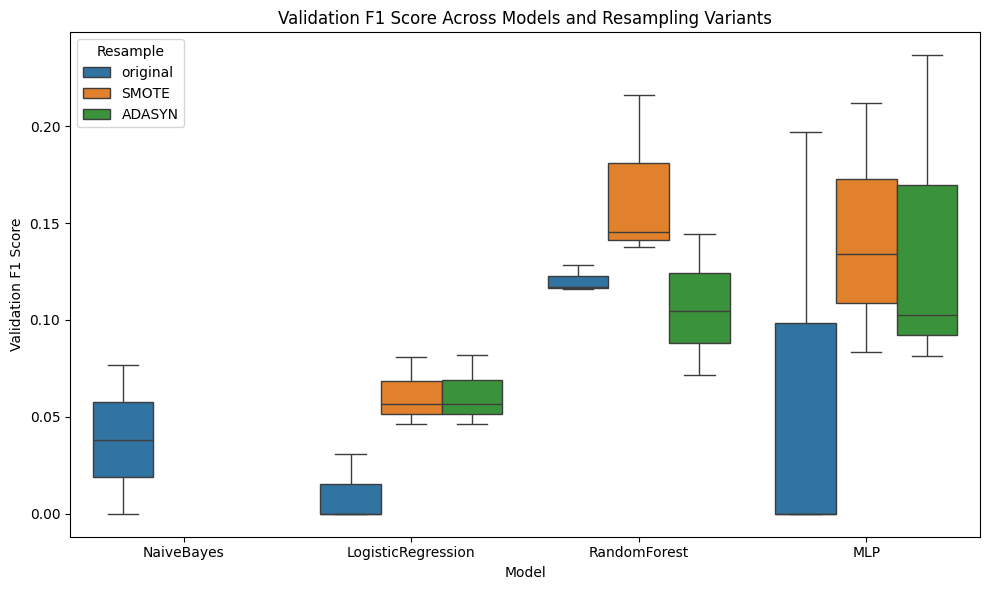

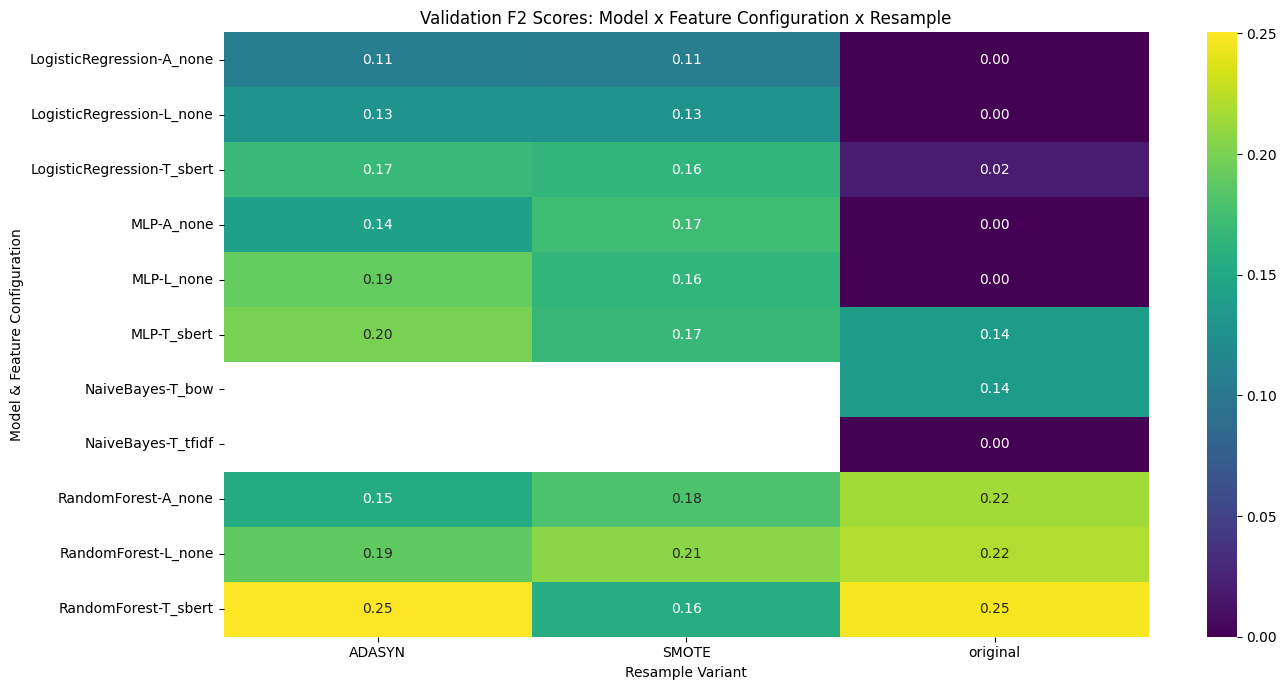

Best Validation F2 Score per Model:


,model,feature_set,embedding,resample,val_f2,test_f2,best_params
10,LogisticRegression,T,sbert,ADASYN,0.168269,0.137051,"{'C': 0.01, 'penalty': 'l2', 'solver': 'liblin..."
28,MLP,T,sbert,ADASYN,0.199275,0.092251,"{'activation': 'relu', 'alpha': 0.1, 'hidden_l..."
1,NaiveBayes,T,bow,original,0.137825,0.099388,{'alpha': 1.0}
19,RandomForest,T,sbert,ADASYN,0.250417,0.176174,"{'class_weight': None, 'max_depth': 10, 'min_s..."


In [64]:
# Load results
df_results = pd.read_csv(BASELINE_RESULTS_FILE) 

#  Compare F1 Score Across Models and Variants 
plt.figure(figsize=(10, 6))
sns.boxplot(x="model", y="val_f1", hue="resample", data=df_results)
plt.title("Validation F1 Score Across Models and Resampling Variants")
plt.ylabel("Validation F1 Score")
plt.xlabel("Model")
plt.legend(title="Resample")
plt.savefig(f"{RESULTS_DIR}/f1_scores_baseline.png", format="png", dpi=300)
plt.tight_layout()
plt.show()


#  Pivot Table: Heatmap of F2 Scores 
# Create a new column that combines feature_set and embedding
df_results["feature_config"] = df_results["feature_set"] + "_" + df_results["embedding"]

# Pivot using the combined feature config
pivot = df_results.pivot_table(
    index=["model", "feature_config"],
    columns="resample",
    values="val_f2",
    aggfunc="max"
)

# Plot
plt.figure(figsize=(14, 7))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="viridis")
plt.title("Validation F2 Scores: Model x Feature Configuration x Resample")
plt.ylabel("Model & Feature Configuration")
plt.xlabel("Resample Variant")
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/f2_scores_baseline.png", format="png", dpi=300)
plt.show()

# Best F2 Score by Model 
idx_best_f2 = df_results.groupby("model")["val_f2"].idxmax()
df_best_f2 = df_results.loc[idx_best_f2]
print("Best Validation F2 Score per Model:")
display(df_best_f2[["model", "feature_set", "embedding", "resample", "val_f2", "test_f2", "best_params"]])

### Advanced Fusions

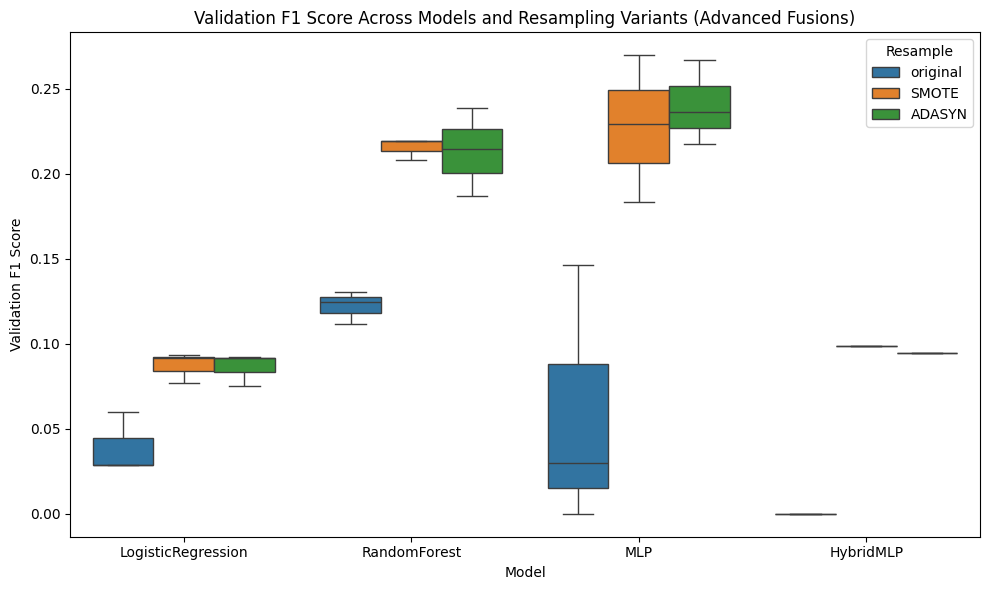

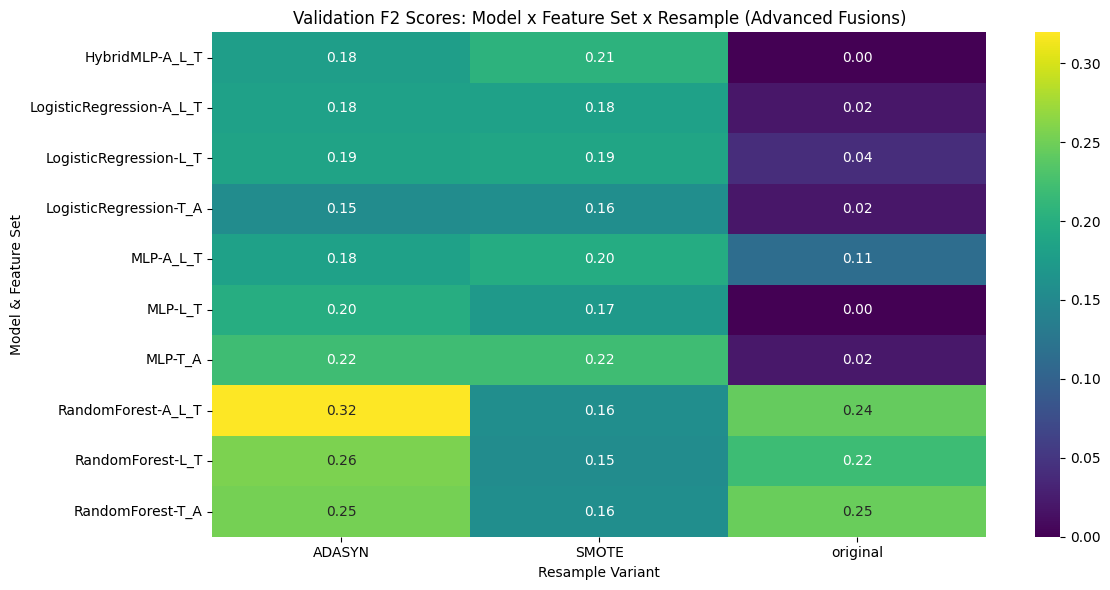

Best Validation F2 Score per Model (Advanced Fusions):


,model,feature_set,embedding,resample,val_f2,test_f2,best_params
19,HybridMLP,A_L_T,sbert,SMOTE,0.205909,0.153061,keras_default
1,LogisticRegression,L_T,sbert,SMOTE,0.188285,0.134062,"{'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}"
28,MLP,T_A,sbert,SMOTE,0.220588,0.094697,"{'activation': 'relu', 'alpha': 0.0001, 'hidde..."
11,RandomForest,A_L_T,sbert,ADASYN,0.319516,0.170455,"{'class_weight': None, 'max_depth': 10, 'min_s..."


In [68]:
# Load advanced fusion results
df_fusion = pd.read_csv(ADVANCED_RESULTS_FILE)

#Compare F1 Score Across Models and Variants 
plt.figure(figsize=(10, 6))
sns.boxplot(x="model", y="val_f1", hue="resample", data=df_fusion)
plt.title("Validation F1 Score Across Models and Resampling Variants (Advanced Fusions)")
plt.ylabel("Validation F1 Score")
plt.xlabel("Model")
plt.legend(title="Resample")
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/f1_scores_advanced.png", format="png", dpi=300)
plt.show()

#Pivot Table: Heatmap of F2 Scores 
pivot_fusion = df_fusion.pivot_table(
    index=["model", "feature_set"],
    columns="resample",
    values="val_f2",
    aggfunc="max"
)
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_fusion, annot=True, fmt=".2f", cmap="viridis")
plt.title("Validation F2 Scores: Model x Feature Set x Resample (Advanced Fusions)")
plt.ylabel("Model & Feature Set")
plt.xlabel("Resample Variant")
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/f2_scores_advanced.png", format="png", dpi=300)
plt.show()

# Best F2 Score by Model 
idx_best_f2_fusion = df_fusion.groupby("model")["val_f2"].idxmax()
df_best_f2_fusion = df_fusion.loc[idx_best_f2_fusion]
print("Best Validation F2 Score per Model (Advanced Fusions):")
display(df_best_f2_fusion[["model", "feature_set", "embedding", "resample", "val_f2", "test_f2", "best_params"]])

In [ ]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load your trained Random Forest model
rf_model = joblib.load("/work/nlp_final/training_sets/saved_models/rf_A_L_T_sbert_ADASYN.joblib")

# 2. Use the feature names you just confirmed
feature_names = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
                 'instrumentalness', 'liveness', 'valence', 'tempo', 'ly_num_chars', 'ly_vocab_size',
                 'ly_ttr', 'ly_top5_ratio', 'ly_ngram_repetition', 'ly_rhyme_like_ratio'] + \
                [f'sbert_{i}' for i in range(384)]  # total 401 features

# 3. Extract feature importances
importances = rf_model.feature_importances_

# 4. Create a DataFrame and sort
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# 5. Print top 10 features
print(importance_df.head(10))

# 6. Plot top 10
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"].head(10)[::-1], importance_df["Importance"].head(10)[::-1])
plt.xlabel("Feature Importance")
plt.title("Top 10 Most Important Features (Random Forest - A_L_T + SBERT + ADASYN)")
plt.tight_layout()
plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=068aa808-4695-4d75-a14b-785a94b3cf38' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>